In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import *
from random import seed
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline

seed(888)

Load exploration data and training data

In [30]:
# load data from pickle and convert to dataframe
brain_test = pd.read_pickle("1_brain_test.pkl")
brain_train = pd.read_pickle("1_brain_train.pkl")
main_test = pd.read_pickle("1_main_test.pkl")
main_train = pd.read_pickle("1_main_train.pkl")
brain_test = pd.DataFrame(brain_test)
brain_train = pd.DataFrame(brain_train)
main_test = pd.DataFrame(main_test)
main_train = pd.DataFrame(main_train)

Accelerometer data preprocessing
1. Check wear time and data quality
2. Exclude people with insufficient weartime and poor data quality
3. Categorize physical activity

People excluded due to wear time < 8000 minutes: 1181
Yes    8377
No        0
Name: data_quality_good_wear_time_f90015_0_0, dtype: int64
Yes    8377
No        0
Name: data_quality_good_calibration_f90016_0_0, dtype: int64


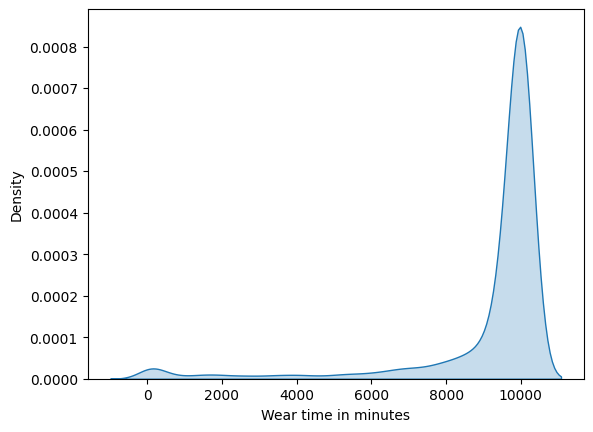

In [31]:
# get weartime duration in minutes (it's in days at default)
main_test["Wear time in minutes"] = main_test.iloc[:,16686]*1440
sns.kdeplot(data = main_test, x= 'Wear time in minutes', fill=True)

# exclude people with insufficient weartime weartime < 8000 minutes
wear_time_test = main_test[main_test["Wear time in minutes"]<8000].index
print("People excluded due to wear time < 8000 minutes:", len(wear_time_test))
brain_test = brain_test.drop(wear_time_test)
main_test = main_test.drop(wear_time_test)

# check wear time and data quality
print(main_test.iloc[:,16650].value_counts())
print(main_test.iloc[:,16651].value_counts())

(0.0, 0.01)

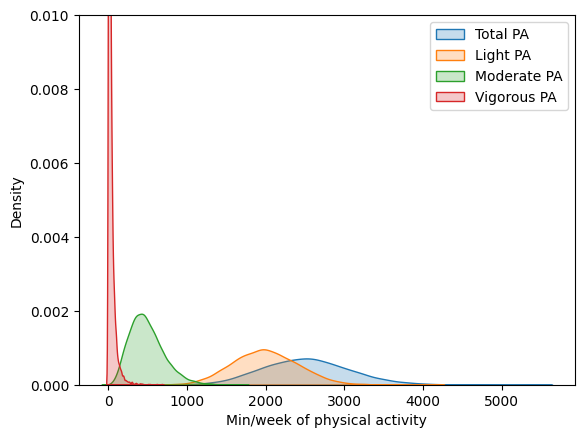

In [32]:
# distributions are cumulative -> substract ditributions from each other
# determine fraction of weartime spent doing light PA (between 30 and 125 milligravites)
light_PA = np.asarray(main_test.iloc[:,16763]-main_test.iloc[:,16748])
# get it in minutes / week
light_PA = light_PA * main_test["Wear time in minutes"]
main_test["Light PA"] = light_PA

# determine fraction of weartime spent doing moderate PA (between 125 and 400 milligravites)
moderate_PA = np.asarray(main_test.iloc[:,16774]-main_test.iloc[:,16763])
moderate_PA = moderate_PA * main_test["Wear time in minutes"]
main_test["Moderate PA"] = moderate_PA

# determine fraction of weartime spent doing vigorous PA (above 400 milligravites)
vigorous_PA = np.asarray(1-main_test.iloc[:,16774])
vigorous_PA = vigorous_PA * main_test["Wear time in minutes"]
main_test["Vigorous PA"] = vigorous_PA

# fraction of weartime for above 30 mg -> total summed light, moderate, and vigorous PA
total_PA = np.asarray(1-main_test.iloc[:,16748])
total_PA = total_PA * main_test["Wear time in minutes"]
main_test["Total PA"] = total_PA

sns.kdeplot(data = main_test, x= 'Total PA', fill=True, label = "Total PA")
sns.kdeplot(data = main_test, x= 'Light PA', fill=True, label = "Light PA")
sns.kdeplot(data = main_test, x= 'Moderate PA', fill=True, label = "Moderate PA")
sns.kdeplot(data = main_test, x= 'Vigorous PA', fill=True, label = "Vigorous PA")
plt.xlabel("Min/week of physical activity")
plt.legend()
plt.ylim(0,0.01)

Exclusion of subjects base on
- Self-reported long standing illness, disability or infirmity
- Disorders of the nervous system
- Malicious neoplasm in the brain
- Circulatory disease
- Not good or excellent self rated health

Make a dataframe with all subjects for comparison
-> add a column that indicates whether that subject would have been excluded (1) or not (0)


In [33]:
print("Size of test set before exclusions:", main_test.shape[0])
print("Size of train set before exclusions:", main_train.shape[0])


main_train_all = main_train
main_test_all = main_test
brain_train_all = brain_train
brain_test_all = brain_test
main_train_all["Excluded"] = 0
main_test_all["Excluded"] = 0

# exclude people with long standing illness diability or infirmity
index_illness_train = main_train[main_train["longstanding_illness_disability_or_infirmity_f2188_0_0"]!= "No"].index
index_illness_test = main_test[main_test["longstanding_illness_disability_or_infirmity_f2188_0_0"]!= "No"].index
brain_train = brain_train.drop(index_illness_train)
brain_test = brain_test.drop(index_illness_test)
main_test = main_test.drop(index_illness_test)
main_train = main_train.drop(index_illness_train)
main_test_all.loc[index_illness_test,"Excluded"] = 1
main_train_all.loc[index_illness_train,"Excluded"] = 1
print("People excluded due to long standing illness (Self-report):","Train Set -", len(index_illness_train),"; Test Set - ", len(index_illness_test))

# exclude people with disorders of the nervous system
nervous_train = main_train[main_train["diagnoses_icd10_f41270_0_0"].str.contains("G")==True].index
nervous_test = main_test[main_test["diagnoses_icd10_f41270_0_0"].str.contains("G")==True].index
brain_train = brain_train.drop(nervous_train)
brain_test = brain_test.drop(nervous_test)
main_test = main_test.drop(nervous_test)
main_train = main_train.drop(nervous_train)
main_test_all.loc[nervous_test,"Excluded"] = 1
main_train_all.loc[nervous_train,"Excluded"] = 1
print("People excluded due to disorders of the nervous system (G):","Train Set -", len(nervous_train),"; Test Set - ", len(nervous_test))

# exclude people with malicious neoplasm in the brain
neoplasm_train = main_train[main_train["diagnoses_icd10_f41270_0_0"].str.contains("C71")==True].index
neoplasm_test = main_test[main_test["diagnoses_icd10_f41270_0_0"].str.contains("C71")==True].index
brain_train = brain_train.drop(neoplasm_train)
brain_test = brain_test.drop(neoplasm_test)
main_test = main_test.drop(neoplasm_test)
main_train = main_train.drop(neoplasm_train)
main_test_all.loc[neoplasm_test,"Excluded"] = 1
main_train_all.loc[neoplasm_train,"Excluded"] = 1
print("People excluded due to malicious neoplasms in the brain (C71):","Train Set -", len(neoplasm_train),"; Test Set - ", len(neoplasm_test))

# exclude people with circulatory disease 
circulatory_train = main_train[main_train["diagnoses_icd10_f41270_0_0"].str.contains("I")==True].index
circulatory_test = main_test[main_test["diagnoses_icd10_f41270_0_0"].str.contains("I")==True].index
brain_train = brain_train.drop(circulatory_train)
brain_test = brain_test.drop(circulatory_test)
main_test = main_test.drop(circulatory_test)
main_train = main_train.drop(circulatory_train)
main_test_all.loc[circulatory_test,"Excluded"] = 1
main_train_all.loc[circulatory_train,"Excluded"] = 1
print("People excluded due to circulatory disease (I):","Train Set -", len(circulatory_train),"; Test Set - ", len(circulatory_test))

# exclude people who don't have good or excellent self-rated health
health_train = main_train[(main_train["overall_health_rating_f2178_0_0"]!= "Good") & (main_train["overall_health_rating_f2178_0_0"]!= "Excellent")].index
health_test = main_test[(main_test["overall_health_rating_f2178_0_0"]!= "Good") & (main_test["overall_health_rating_f2178_0_0"]!= "Excellent")].index
brain_train = brain_train.drop(health_train)
brain_test = brain_test.drop(health_test)
main_test = main_test.drop(health_test)
main_train = main_train.drop(health_train)
main_test_all.loc[health_test,"Excluded"] = 1
main_train_all.loc[health_train,"Excluded"] = 1
print("People excluded due to not good or excellent health (Self-report):","Train Set -", len(health_train),"; Test Set - ", len(health_test))

print("Size of test set after exclusions:", main_test.shape[0])
print("Size of train set after exclusions:", main_train.shape[0])

Size of test set before exclusions: 8377
Size of train set before exclusions: 24035
People excluded due to long standing illness (Self-report): Train Set - 6051 ; Test Set -  1992
People excluded due to disorders of the nervous system (G): Train Set - 481 ; Test Set -  190
People excluded due to malicious neoplasms in the brain (C71): Train Set - 6 ; Test Set -  1
People excluded due to circulatory disease (I): Train Set - 1380 ; Test Set -  476
People excluded due to not good or excellent health (Self-report): Train Set - 1535 ; Test Set -  420
Size of test set after exclusions: 5298
Size of train set after exclusions: 14582


## Select variables of interest

In [34]:
# select data for later analysis
main_test_crop = []
main_test_crop = pd.DataFrame(main_test_crop)

main_test_all['uk_biobank_assessment_centre_f54_2_0'] = main_test_all['uk_biobank_assessment_centre_f54_2_0'].map({'11025': 'Cheadle', '11026': 'Reading','11027': 'Newcastle', '11028': 'Bristol'})
print(main_test_all['uk_biobank_assessment_centre_f54_2_0'].value_counts())

main_test_crop["Age"] = main_test["Age"]
main_test_crop["Gender"] = main_test.iloc[:,22]
main_test_crop["Total PA"] = main_test["Total PA"]
main_test_crop["Vigorous PA"] = main_test["Vigorous PA"]
main_test_crop["Moderate PA"] = main_test["Moderate PA"]
main_test_crop["Light PA"] = main_test["Light PA"]
main_test_crop["BMI"] = main_test.iloc[:,11580]
main_test_crop["ECG max workload"] = main_test.iloc[:, 5773]
main_test_crop["ECG max heart rate"] = main_test.iloc[:, 5775]
main_test_crop["SR Walking PA"] = main_test.iloc[:,9989]
main_test_crop["SR Moderate PA"] = main_test.iloc[:,9990]
main_test_crop["SR Vigorous PA"] = main_test.iloc[:,9991]
#main_test_crop["Job PA"] = main_test.iloc[:,507]
main_test_crop["Hand grip L"] = main_test.iloc[:,64]
main_test_crop["Hand grip R"] = main_test.iloc[:,68]
main_test_crop["Imaging site"] = main_test['uk_biobank_assessment_centre_f54_2_0']
main_test_crop["Smoking"] = main_test.iloc[:,650]
main_test_crop["Townsend deprivation"] = main_test.iloc[:,456]
# ICD diagnosis yes no

# same for full dataset without exclusions
main_test_all_crop = []
main_test_all_crop = pd.DataFrame(main_test_all_crop)

main_test_all_crop["Age"] = main_test_all["Age"]
main_test_all_crop["Gender"] = main_test_all.iloc[:,22]
main_test_all_crop["Total PA"] = main_test_all["Total PA"]
main_test_all_crop["Vigorous PA"] = main_test_all["Vigorous PA"]
main_test_all_crop["Moderate PA"] = main_test_all["Moderate PA"]
main_test_all_crop["Light PA"] = main_test_all["Light PA"]
main_test_all_crop["BMI"] = main_test_all.iloc[:,11580]
main_test_all_crop["ECG max workload"] = main_test_all.iloc[:, 5773]
main_test_all_crop["ECG max heart rate"] = main_test_all.iloc[:, 5775]
main_test_all_crop["SR Walking PA"] = main_test_all.iloc[:,9989]
main_test_all_crop["SR Moderate PA"] = main_test_all.iloc[:,9990]
main_test_all_crop["SR Vigorous PA"] = main_test_all.iloc[:,9991]
#main_test_all_crop["Job PA"] = main_test_all.iloc[:,507]
main_test_all_crop["Hand grip L"] = main_test_all.iloc[:,64]
main_test_all_crop["Hand grip R"] = main_test_all.iloc[:,68]
main_test_all_crop["Excluded"] = main_test_all["Excluded"]
main_test_all_crop["Imaging site"] = main_test_all['uk_biobank_assessment_centre_f54_2_0']
main_test_all_crop["Smoking"] = main_test_all.iloc[:,650]
main_test_all_crop["Townsend deprivation"] = main_test_all.iloc[:,456]


Cheadle      5061
Newcastle    2008
Reading      1296
Bristol        12
Name: uk_biobank_assessment_centre_f54_2_0, dtype: int64


Pickle full dataset with exclusion measure and excluded dataset

In [35]:
# pickle end results 
main_test_crop.to_pickle("2_main_test.pkl")
main_test_all_crop.to_pickle("2_main_test_all.pkl")
main_train.to_pickle("2_main_train.pkl")
brain_test.to_pickle("2_brain_test.pkl")
brain_test_all.to_pickle("2_brain_test_all.pkl")
brain_train.to_pickle("2_brain_train.pkl")